In [62]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.utils import index_to_mask
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt

# Load dataset
data_npz = np.load("data/TAP-city/aberdeen_md.npz", allow_pickle=True)

# Extract node features: use only the first two columns
x_raw = data_npz["x"][:, :2]  # assuming 0 = highway (categorical), 1 = street_count
x_raw_tensor = torch.tensor(x_raw, dtype=torch.float)

# Extract and average edge features
edge_attr_raw = data_npz["edge_attr"][:, :9]  # only first 9 raw edge features
edge_attr_dir = data_npz["edge_attr_dir"]     # (x, y)
edge_attr_ang = data_npz["edge_attr_ang"]     # (min, max, pi)

# Concatenate raw edge features
full_edge_attr = np.concatenate([edge_attr_raw, edge_attr_dir, edge_attr_ang], axis=1)

# Map edge features to nodes (average)
edge_index = data_npz["edge_index"]
node_feature_map = defaultdict(list)

for i, (src, tgt) in enumerate(edge_index):
    node_feature_map[src].append(full_edge_attr[i])
    node_feature_map[tgt].append(full_edge_attr[i])

edge_features_per_node = np.array([
    np.mean(node_feature_map[i], axis=0) if i in node_feature_map else np.zeros(full_edge_attr.shape[1])
    for i in range(x_raw.shape[0])
])

# Concatenate node + aggregated edge features
x_final = np.concatenate([x_raw, edge_features_per_node], axis=1)
x_final_tensor = torch.tensor(x_final, dtype=torch.float)

# Labels and edge_index
y = torch.tensor(data_npz["occur_labels"], dtype=torch.long)
edge_index_tensor = torch.tensor(data_npz["edge_index"].T, dtype=torch.long)

# Final PyG graph
data = Data(x=x_final_tensor, y=y, edge_index=edge_index_tensor)

# Split into train/val/test
all_idx = torch.arange(data.num_nodes)
train_idx, test_idx = train_test_split(all_idx, test_size=0.2, stratify=y, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, stratify=y[train_idx], random_state=42)

data.train_mask = index_to_mask(train_idx, size=data.num_nodes)
data.val_mask = index_to_mask(val_idx, size=data.num_nodes)
data.test_mask = index_to_mask(test_idx, size=data.num_nodes)




In [63]:
# GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Model setup
model = GCN(in_channels=data.x.shape[1], hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
    return acc


# Train model
model.train()
loss_list = []
val_acc_list = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    val_acc = evaluate(data.val_mask)

    # Store values for plotting
    loss_list.append(loss.item())
    val_acc_list.append(val_acc)

    # Print every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 000 | Loss: 3.2732 | Val Acc: 0.9048
Epoch 001 | Loss: 3.1627 | Val Acc: 0.9048
Epoch 010 | Loss: 2.2228 | Val Acc: 0.9048
Epoch 020 | Loss: 1.2297 | Val Acc: 0.9048
Epoch 030 | Loss: 0.4429 | Val Acc: 0.9048
Epoch 040 | Loss: 0.4374 | Val Acc: 0.9048
Epoch 050 | Loss: 0.4694 | Val Acc: 0.9048
Epoch 060 | Loss: 0.4349 | Val Acc: 0.9048
Epoch 070 | Loss: 0.4159 | Val Acc: 0.9048
Epoch 080 | Loss: 0.3817 | Val Acc: 0.9048
Epoch 090 | Loss: 0.3264 | Val Acc: 0.9048
Epoch 100 | Loss: 0.3139 | Val Acc: 0.9048
Epoch 110 | Loss: 0.3085 | Val Acc: 0.9048
Epoch 120 | Loss: 0.3045 | Val Acc: 0.9048
Epoch 130 | Loss: 0.3015 | Val Acc: 0.9048
Epoch 140 | Loss: 0.2992 | Val Acc: 0.9048
Epoch 150 | Loss: 0.2972 | Val Acc: 0.9127
Epoch 160 | Loss: 0.2955 | Val Acc: 0.9127
Epoch 170 | Loss: 0.2940 | Val Acc: 0.9127
Epoch 180 | Loss: 0.2926 | Val Acc: 0.9127
Epoch 190 | Loss: 0.2914 | Val Acc: 0.9127


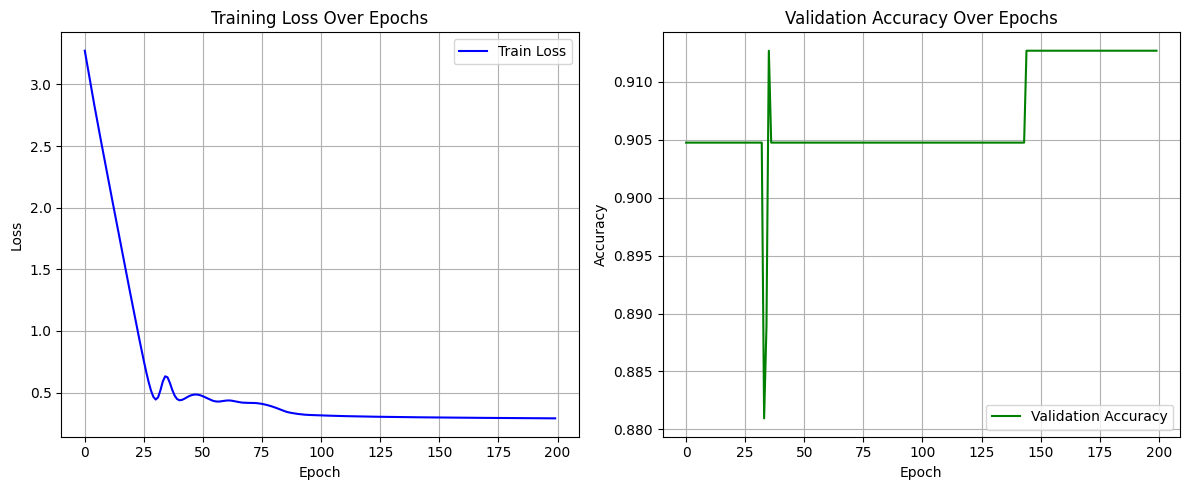

In [64]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss_list, label="Train Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_acc_list, label="Validation Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [65]:
from torch.nn.functional import softmax

# Put model in evaluation mode
model.eval()

# Predict on all nodes
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    probs = softmax(logits, dim=1)
    preds = probs.argmax(dim=1)

# Load coordinates
coordinates = data_npz["coordinates"]
assert len(coordinates) == data.x.shape[0], "Mismatch in coordinate and node count."

feature_names = [
    'node_highway', 'street_count',
    'edge_highway', 'edge_length', 'edge_bridge', 'edge_lanes', 'edge_oneway',
    'edge_maxspeed', 'edge_access', 'edge_tunnel', 'edge_junction',
    'edge_dir_x', 'edge_dir_y',
    'angle_min', 'angle_max', 'angle_pi'
]


# Padding if your final feature count exceeds 14
if data.x.shape[1] > len(feature_names):
    feature_names += [f"feature_{i}" for i in range(len(feature_names), data.x.shape[1])]

# GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=30),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# For each predicted hotspot, explain and output top features
k = 5  # top-k features to show
print(f"\n🔍 HOTSPOT ANALYSIS (Top {k} Features Per Hotspot Node):\n")
for node_idx in range(data.num_nodes):
    if preds[node_idx] == 1:  # predicted hotspot
        explanation = explainer(data.x, data.edge_index, index=int(node_idx))
        feat_mask = explanation.node_mask[node_idx].cpu().detach().numpy()

        # Rank top-k features
        top_k = np.argsort(-feat_mask)[:k]
        feature_scores = [(feature_names[i], feat_mask[i]) for i in top_k]

        # Output
        lat, lon = coordinates[node_idx]
        print(f"📍 Node {node_idx} | Coordinates: ({lat:.6f}, {lon:.6f})")
        for name, score in feature_scores:
            print(f"   - {name}: {score:.4f}")
        print("-" * 50)



🔍 HOTSPOT ANALYSIS (Top 5 Features Per Hotspot Node):

📍 Node 28 | Coordinates: (-76.179475, 39.495750)
   - edge_highway: 0.5581
   - edge_bridge: 0.5334
   - angle_min: 0.4839
   - edge_dir_y: 0.4732
   - node_highway: 0.4693
--------------------------------------------------
📍 Node 37 | Coordinates: (-76.177887, 39.496394)
   - edge_highway: 0.5530
   - node_highway: 0.4739
   - edge_oneway: 0.4689
   - edge_dir_y: 0.4565
   - edge_bridge: 0.4312
--------------------------------------------------
📍 Node 207 | Coordinates: (-76.185625, 39.489470)
   - edge_bridge: 0.5977
   - angle_max: 0.5893
   - edge_highway: 0.5656
   - node_highway: 0.4584
   - edge_access: 0.4553
--------------------------------------------------
📍 Node 208 | Coordinates: (-76.181635, 39.485882)
   - edge_highway: 0.6113
   - edge_lanes: 0.4433
   - angle_max: 0.4289
   - angle_pi: 0.4251
   - edge_access: 0.4246
--------------------------------------------------
📍 Node 475 | Coordinates: (-76.153594, 39.51611